In [31]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import statsmodels.api as sm
from sklearn import metrics
from ggplot import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

In [5]:
# Load in the train and test datasets
train = pd.read_csv('train.csv', encoding = 'latin1')
test = pd.read_csv('test.csv',encoding = 'latin1')
print(len(train))
print(len(test))
# Store our passenger ID for easy access
PassengerId = test['PassengerId']

891
418


In [6]:
full_data = [train, test]
full_data =pd.concat(full_data)
# Some features of my own that I have added in
# Gives the length of the name
full_data['Name_length'] = full_data['Name'].apply(len)
full_data['Has_cabin']=full_data['Cabin'].apply(lambda x:0 if type(x)==float else 1)
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone']=full_data['FamilySize'].apply(lambda x:0 if x>1 else 1)
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())
#########################################
full_data['CategoricalFare'] = 0
full_data.loc[full_data['Fare'] <=7.91,'CategoricalFare'] = 0
full_data.loc[(full_data['Fare'] >7.91) & (full_data['Fare'] <=14.45),'CategoricalFare'] = 1
full_data.loc[(full_data['Fare'] >14.45) & (full_data['Fare'] <=31),'CategoricalFare'] = 2
full_data.loc[(full_data['Fare'] >31),'CategoricalFare'] = 3
#########################################
full_data['CategoricalAge'] =0
avg_age  = full_data['Age'].mean()
std_age  = full_data['Age'].std()
null_age_cnt = full_data['Age'].isnull().sum()
age_null_random_list = np.random.randint(avg_age - std_age,avg_age + std_age,size =null_age_cnt)
full_data['Age'][np.isnan(full_data['Age'])] = age_null_random_list
full_data['Age'] = full_data['Age'].astype(int)
full_data.loc[full_data['Age'] <=16,'CategoricalAge'] = 0
full_data.loc[(full_data['Age'] >16) & (full_data['Age'] <=32),'CategoricalAge'] = 1
full_data.loc[(full_data['Age'] >32) & (full_data['Age'] <=48),'CategoricalAge'] = 2
full_data.loc[(full_data['Age'] >48) & (full_data['Age'] <=64),'CategoricalAge'] = 3
full_data.loc[(full_data['Age'] >64),'CategoricalAge'] = 4
########################################
full_data['Title']=full_data['Name'].apply(lambda x:re.search(' ([A-Za-z]+)\.',x).group(1))
full_data['Title'] = full_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],"Rare")
full_data['Title'] = full_data['Title'].replace(['Ms'],'Miss')
full_data['Title'] = full_data['Title'].replace(['Mlle'],'Miss')
full_data['Title'] = full_data['Title'].replace(['Mme'],'Mrs')
full_data.Title.unique()
title_map ={"Mr":1,"Miss":2,"Mrs": 3, "Master": 4, "Rare": 5}
full_data['Title']=full_data['Title'].map(title_map).astype(int)
###########################################
null_sex_cnt = full_data['Sex'].isnull().sum()
full_data['Sex']=full_data['Sex'].map({'male':1,"female":2}).astype(int)
##########################################
full_data['Embarked'] = full_data['Embarked'].fillna('S')
full_data['Embarked'] = full_data['Embarked'].map({"S":1,"C":2,"Q":3}).astype(int)
train = full_data.iloc[0:891,]
test =  full_data.iloc[891:1309,]
#age_null_random_list

In [7]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

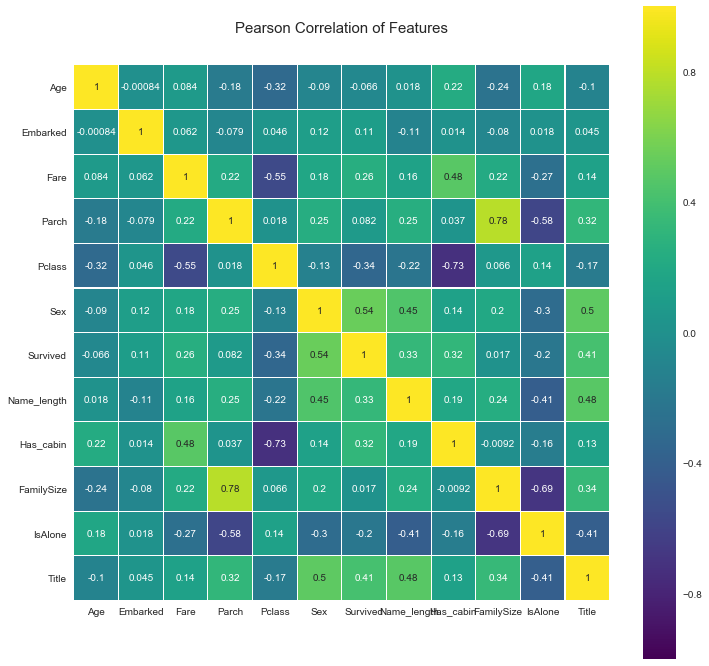

In [8]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [9]:
#train.Sex.unique()
train.columns

Index(['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'Survived',
       'Name_length', 'Has_cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

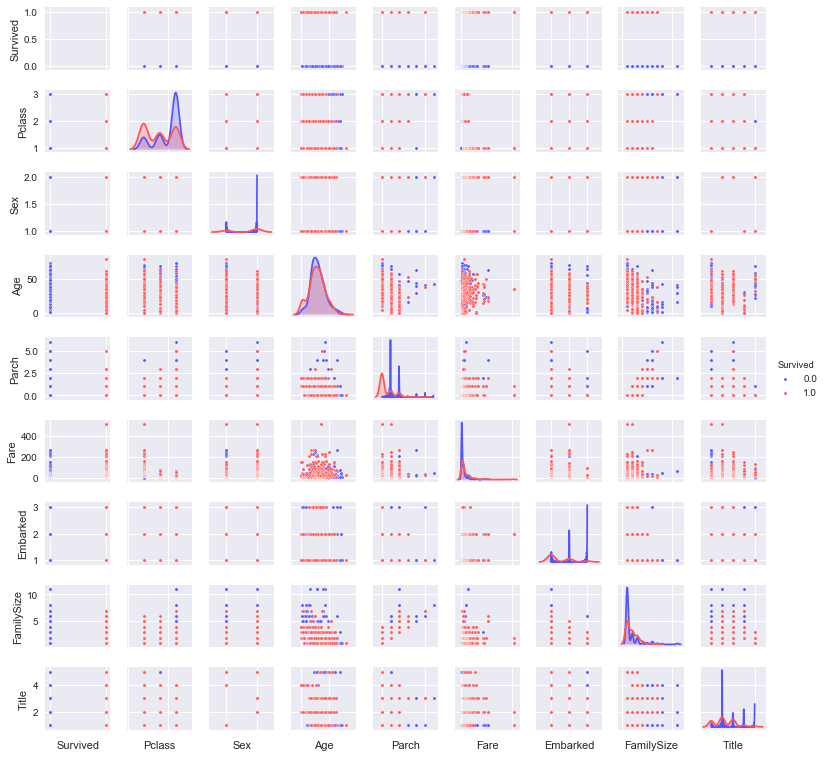

In [10]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

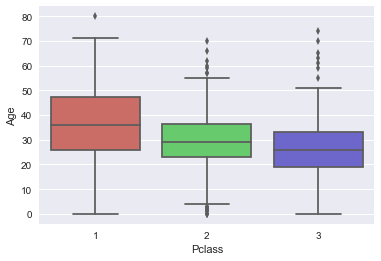

In [11]:
#sb.countplot(x='Survived',data=train, palette='hls')
sb.boxplot(x='Pclass', y='Age', data=train, palette='hls')

In [14]:
cols = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex',
       'Name_length', 'Has_cabin', 'FamilySize', 'IsAlone', 'Title']
logit = sm.Logit(train['Survived'], train[cols])
result = logit.fit_regularized(method = 'l1')
#print(result.params)
model_llh = logit.loglike(result.params)
#print (model_llh)
for i in cols:
    print(i,",",np.corrcoef(list(train['Survived']), list(train[i]))[0, 1])

###Contribution of variables
log = [0] * len(cols)
attribute = [0] * len(cols)
for i in range (0,len(cols)):
    train_cols_comp = np.delete(cols,i)
    logit = sm.Logit(train['Survived'],train[train_cols_comp], missing = 'drop')
    rs = logit.fit_regularized(method = 'l1')
    var_comp = pd.DataFrame()
    log[i] = logit.loglike(rs.params)
    attribute[i] = cols[i]
    var_comp = pd.DataFrame({'Atribute' : attribute, 'Loglikelihood' : log, 'Entire_model' : model_llh})
    var_comp['Difference']    = model_llh - var_comp['Loglikelihood']
    var_comp['%Contribution'] = (var_comp['Difference']/var_comp['Difference'].sum())*100
    var_comp['%Contribution'] = var_comp['%Contribution'].round(2)
    var_comp = var_comp.sort_values(by = '%Contribution',ascending= False ,axis = 0)
var_comp

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42424654395265
            Iterations: 48
            Function evaluations: 56
            Gradient evaluations: 48
Age , -0.0655543220597
Embarked , 0.106811385709
Fare , 0.257306522385
Parch , 0.0816294070835
Pclass , -0.338481035961
Sex , 0.543351380658
Name_length , 0.332349534423
Has_cabin , 0.316911523112
FamilySize , 0.0166389892827
IsAlone , -0.2033670857
Title , 0.40775315642
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4459754284593634
            Iterations: 46
            Function evaluations: 52
            Gradient evaluations: 46
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42515761649766665
            Iterations: 44
            Function evaluations: 52
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.424

,Atribute,Entire_model,Loglikelihood,Difference,%Contribution
5,Sex,-378.003671,-428.042098,50.038427,40.69
4,Pclass,-378.003671,-398.456560,20.452890,16.63
0,Age,-378.003671,-397.364107,19.360436,15.74
8,FamilySize,-378.003671,-393.438170,15.434500,12.55
10,Title,-378.003671,-386.733358,8.729687,7.10
9,IsAlone,-378.003671,-382.648014,4.644344,3.78
7,Has_cabin,-378.003671,-379.584659,1.580988,1.29
3,Parch,-378.003671,-379.218024,1.214353,0.99
1,Embarked,-378.003671,-378.815436,0.811766,0.66
6,Name_length,-378.003671,-378.526269,0.522598,0.42


In [28]:
def prediction(data,col):
    #print(data.head(10))
    predicted = result.predict(data[col])
    #print(predicted)
    #print(np.count_nonzero(~np.isnan(predicted)))
    actual = data['Survived']
    pa = pd.DataFrame(list(predicted),list(actual)).reset_index()
    pa = pa.rename(columns = {'index' : 'Actual', 0 : 'Probability'})
    print(pa)
    pa['Predicted'] = np.where(pa['Probability'] >= 0.373515,1,0)
    pa = pa.astype('int64')
    C = confusion_matrix(pa['Actual'], pa['Predicted'])
    return pa,C

ret_data_train,C=prediction(train,cols)
C

     Actual  Probability
0       0.0     0.060023
1       0.0     0.360974
2       1.0     0.101371
3       0.0     0.120000
4       0.0     0.130774
5       0.0     0.246970
6       0.0     0.156583
7       0.0     0.135938
8       0.0     0.035617
9       0.0     0.521395
10      0.0     0.202229
11      0.0     0.160635
12      0.0     0.373490
13      0.0     0.458446
14      0.0     0.692074
15      0.0     0.131306
16      0.0     0.441604
17      0.0     0.023532
18      0.0     0.083651
19      0.0     0.052904
20      0.0     0.070679
21      0.0     0.139666
22      0.0     0.159601
23      0.0     0.736766
24      0.0     0.072399
25      0.0     0.084570
26      0.0     0.041767
27      1.0     0.089796
28      0.0     0.092738
29      0.0     0.125763
..      ...          ...
861     1.0     0.828090
862     0.0     0.961150
863     1.0     0.883464
864     0.0     0.946865
865     1.0     0.918492
866     1.0     0.924494
867     0.0     0.538045
868     1.0     0.901613


array([[441, 108],
       [ 64, 278]])

Area Under The Curve:0.8080720928
Threshold is :[2 1 0]


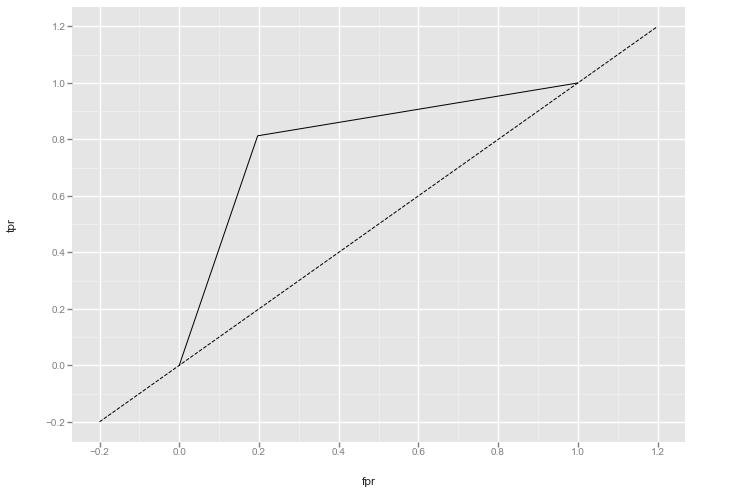

<ggplot: (112263090489)>

In [29]:
def getroc(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    #print(threshold)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    #print(roc.head(10))
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    #print((roc['threshold']) )
    roc_auc = auc(fpr, tpr)
    print('Area Under The Curve:%s' %roc_auc)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    return threshold,df

threshold, ret_dt=getroc(ret_data_train['Actual'],ret_data_train['Predicted'])
###Plot ROC
print('Threshold is :%s' %threshold)
ggplot(ret_dt, aes(x='fpr', y='tpr')) +\
        geom_line() +\
        geom_abline(linetype='dashed')


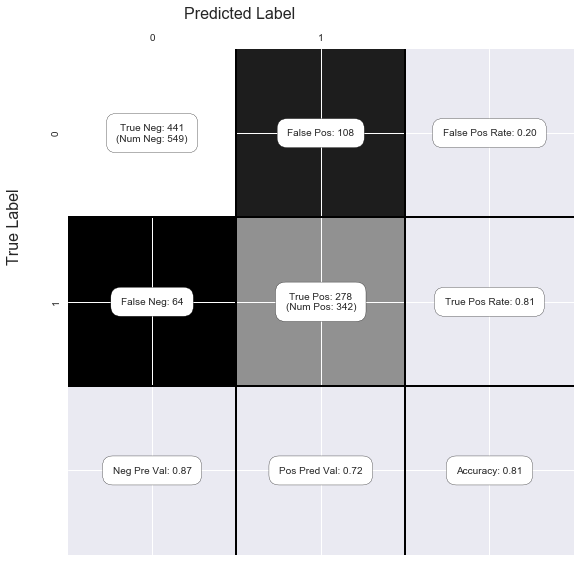

In [30]:

class_labels=['0','1']
assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];
NP = fn+tp # Num positive examples
NN = tn+fp # Num negative examples
N  = NP+NN
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)
ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

# Draw the grid boxes
ax.set_xlim(-0.5,2.5)
ax.set_ylim(2.5,-0.5)
ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

# Set xlabels
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_xticks([0,1,2])
ax.set_xticklabels(class_labels + [''])
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
# These coordinate might require some tinkering. Ditto for y, below.
ax.xaxis.set_label_coords(0.34,1.06)

# Set ylabels
ax.set_ylabel('True Label', fontsize=16, rotation=90)
ax.set_yticklabels(class_labels + [''],rotation=90)
ax.set_yticks([0,1,2])
ax.yaxis.set_label_coords(-0.09,0.65)

# Fill in initial metrics: tp, tn, etc...
ax.text(0,0,'True Neg: %d\n(Num Neg: %d)'%(tn,NN),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(0,1,'False Neg: %d'%fn,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(1,0,'False Pos: %d'%fp,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(1,1,'True Pos: %d\n(Num Pos: %d)'%(tp,NP),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
# Fill in secondary metrics: accuracy, true pos rate, etc...
ax.text(2,0,'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(2,1,'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(2,2,'Accuracy: %.2f'%((tp+tn+0.)/N),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(0,2,'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
ax.text(1,2,'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
plt.tight_layout()
plt.show()

In [35]:
Y = train["Survived"]
X = train[cols]
dt_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
dt_gini.fit(X, Y)

dt_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                                    max_depth=3, min_samples_leaf=5)
dt_entropy.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [ ]:
print(np.count_nonzero(~np.isnan(test['Survived'])))

In [3]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Unnamed: 12
0,180,0,3,"Leonard, Mr. Lionel",male,36.00,0,0,LINE,0.0000,NaN,S,NaN
1,264,0,1,"Harrison, Mr. William",male,40.00,0,0,112059,0.0000,B94,S,NaN
2,272,1,3,"Tornquist, Mr. William Henry",male,25.00,0,0,LINE,0.0000,NaN,S,NaN
3,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S,NaN
4,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.00,0,0,LINE,0.0000,NaN,S,NaN
5,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S,NaN
6,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S,NaN
7,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,891.0
8,598,0,3,"Johnson, Mr. Alfred",male,49.00,0,0,LINE,0.0000,NaN,S,418.0
9,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,NaN
